# Cohort 60x60 Ratios validation analysis

### Imports and environment setup

- Date of run: 2024-12-30
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
from scipy import stats
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression


In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


## Loading the data

In [4]:
# Load the uploaded dataset
file_path_mmk = '../data/60x60_dr_mmk_20241209.csv'
data_mmk = pd.read_csv(file_path_mmk, delimiter='\t')

# Rename column with trailing space
data_mmk.rename(columns={'KPYM ng/mL ': 'KPYM ng/mL'}, inplace=True)

# Define features and target
biomarkers = ['MMP9 ng/mL', 'HSPB1 ng/mL', 'PERM ng/mL', 'ADIPOQ ng/mL', 'TIMP-2 ng/mL', 'AGRIN ng/mL', 'KPYM ng/mL']
target = 'Collected volume (mL)'

# Preprocess data
data_mmk[biomarkers] = data_mmk[biomarkers].apply(pd.to_numeric, errors='coerce')

# Make the data log-transformed
data_mmk[biomarkers] = data_mmk[biomarkers].apply(lambda x: np.log(x + 1))
data_mmk[target] = data_mmk[target].apply(lambda x: np.log(x + 1))

data_clean = data_mmk[["Sample"] + biomarkers + [target] + ["Pathology"]].dropna()
# Convert pathology to binary
data_clean["Pathology"] = data_clean["Pathology"].apply(lambda x: 1 if x == "Endometrial cancer" else 0)


## Create the ratios

In [5]:
# Create all possible ratios
ratios = []
for biomarker1, biomarker2 in itertools.combinations(biomarkers, 2):
    ratio_name = f"{biomarker1}_to_{biomarker2}"
    data_clean[ratio_name] = np.where(data_clean[biomarker2] != 0, 
                                      data_clean[biomarker1] / data_clean[biomarker2], 
                                      np.nan)
    ratios.append(ratio_name)

# Drop rows with NaN values resulting from invalid ratios
data_ratios = data_clean.dropna()

## Plot the correlations between ratios and collected volume

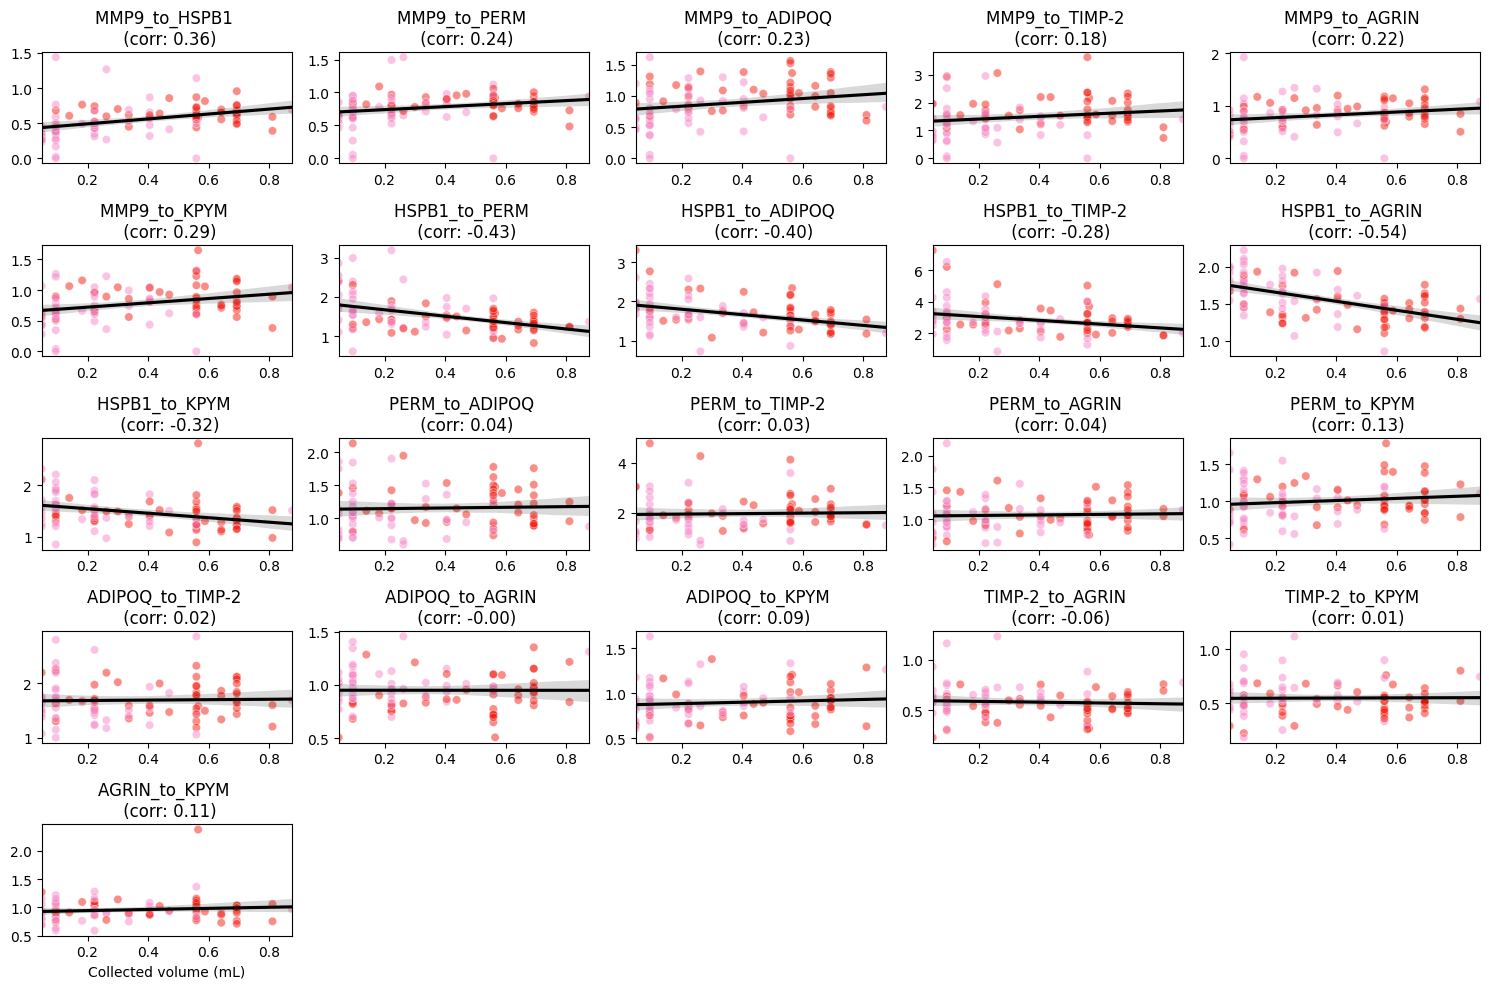

In [6]:
custom_palette = {0: "#f789c8", 1: "#f41c11"}  # Use MMK colors

# Calculate the number of rows and columns for the grid
num_plots = len(ratios)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array if it's not already flat
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate over the ratios and plot each one
for i, ratio in enumerate(ratios):
    row = i // num_cols
    col = i % num_cols
    
    # Calculate the correlation coefficient
    corr = data_ratios[target].corr(data_ratios[ratio])

    # calculate the p-value of the independence test between the two variables (not normally distributed)
    _, p_value = stats.spearmanr(data_ratios[target], data_ratios[ratio])

    are_disjoint = p_value > 0.05

    # Plot the scatterplot and regression line
    sns.scatterplot(data=data_ratios, x=target, y=ratio, ax=axes[row, col], hue='Pathology', alpha=0.5, legend=False, palette=custom_palette)
    sns.regplot(data=data_ratios, x=target, y=ratio, scatter=False, ax=axes[row, col], color='black')
    
    # Set the title
    axes[row, col].set_title(f"{ratio.replace(" ng/mL", "")} \n (corr: {corr:.2f})")

    # remove the x-axis label for all but the bottom row
    if row != num_rows - 1:
        axes[row, col].set_xlabel('')

    # remove the y-axis label for all but the left column
    axes[row, col].set_ylabel('')

# Remove any unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
    

## Plotting the correlation between the biomarker readouts and the collected volume

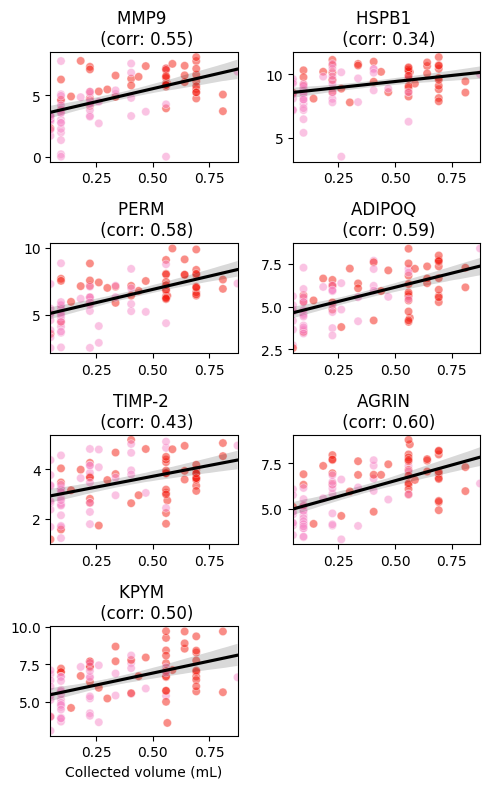

In [7]:

# Calculate the number of rows and columns for the grid
num_plots = len(biomarkers)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 8))

# Flatten the axes array if it's not already flat
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate over the ratios and plot each one
for i, ratio in enumerate(biomarkers):
    row = i // num_cols
    col = i % num_cols
    
    # Calculate the correlation coefficient
    corr = data_ratios[target].corr(data_ratios[ratio])

    # calculate the p-value of the independence test between the two variables (not normally distributed)
    _, p_value = stats.spearmanr(data_ratios[target], data_ratios[ratio])

    are_disjoint = p_value > 0.05

    # Plot the scatterplot and regression line
    sns.scatterplot(data=data_ratios, x=target, y=ratio, ax=axes[row, col], hue='Pathology', alpha=0.5, legend=False, palette=custom_palette)
    sns.regplot(data=data_ratios, x=target, y=ratio, scatter=False, ax=axes[row, col], color='black')
    
    # Set the title
    axes[row, col].set_title(f"{ratio.replace(" ng/mL", "")} \n (corr: {corr:.2f})")

    # remove the x-axis label for all but the bottom row
    if row != num_rows - 1:
        axes[row, col].set_xlabel('')

    # remove the y-axis label for all but the left column
    axes[row, col].set_ylabel('')

# Remove any unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
    

## Measuring the decrease of $R^2$ in ratios

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize lists to store results
biomarker_r2 = []
ratio_r2 = []

# Independent variable (c.v.)
X = data_ratios[['Collected volume (mL)']].values  # Ensure X is 2D

# Loop through biomarkers
for biomarker in biomarkers:
    # Dependent variable
    y = data_ratios[biomarker].values.reshape(-1, 1)
    
    # Linear regression
    model = LinearRegression().fit(X, y)
    
    # Compute R^2
    r2 = model.score(X, y)
    biomarker_r2.append((biomarker, r2))

# Loop through ratios
for ratio in ratios:
    # Dependent variable
    y = data_ratios[ratio].values.reshape(-1, 1)
    
    # Linear regression
    model = LinearRegression().fit(X, y)
    
    # Compute R^2
    r2 = model.score(X, y)
    ratio_r2.append((ratio, r2))

# Convert results to DataFrames for easy comparison
biomarker_r2_df = pd.DataFrame(biomarker_r2, columns=['Biomarker', 'R2'])
ratio_r2_df = pd.DataFrame(ratio_r2, columns=['Ratio', 'R2'])


Show the $R^2$ for biomarkers with respect to collected volume 

In [9]:
biomarker_r2_df

,Biomarker,R2
0,MMP9 ng/mL,0.302725
1,HSPB1 ng/mL,0.118730
2,PERM ng/mL,0.338614
3,ADIPOQ ng/mL,0.346545
4,TIMP-2 ng/mL,0.186730
5,AGRIN ng/mL,0.355745
6,KPYM ng/mL,0.245460


Show the $R^2$ for ratios with respect to collected volume 

In [10]:
ratio_r2_df

,Ratio,R2
0,MMP9 ng/mL_to_HSPB1 ng/mL,0.130931
1,MMP9 ng/mL_to_PERM ng/mL,0.057126
2,MMP9 ng/mL_to_ADIPOQ ng/mL,0.051640
3,MMP9 ng/mL_to_TIMP-2 ng/mL,0.033097
4,MMP9 ng/mL_to_AGRIN ng/mL,0.048420
5,MMP9 ng/mL_to_KPYM ng/mL,0.084685
6,HSPB1 ng/mL_to_PERM ng/mL,0.185054
7,HSPB1 ng/mL_to_ADIPOQ ng/mL,0.159347
8,HSPB1 ng/mL_to_TIMP-2 ng/mL,0.078219
9,HSPB1 ng/mL_to_AGRIN ng/mL,0.294321


## Extracting outliers per biomarker

In [14]:
# Initialize a list to store outlier data
outliers = []

# Loop through biomarkers to extract outliers
for biomarker in biomarkers:
    # Prepare data for regression
    X = data_ratios[target].values.reshape(-1, 1)  # Independent variable
    y = data_ratios[biomarker].values  # Dependent variable

    # Fit the regression model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Compute residuals
    residuals = y - y_pred

    # Define the outlier threshold (e.g., 1.5 times the IQR)
    iqr = np.percentile(residuals, 75) - np.percentile(residuals, 25)
    lower_bound = np.percentile(residuals, 25) - 1.5 * iqr
    upper_bound = np.percentile(residuals, 75) + 1.5 * iqr

    # Identify outliers
    outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)
    outlier_indices = np.where(outlier_mask)[0]  # Get positional indices

    # Add outliers to the list
    for idx in outlier_indices:
        original_index = data_ratios.index[idx]  # Map positional index back to original index
        outliers.append({
            "Sample": data_ratios.loc[original_index, 'Sample'],
            "Biomarker": biomarker,
            "Pathology": data_ratios.loc[original_index, 'Pathology'],
            "Outlier Type": "Upregulated" if residuals[idx] > 0 else "Downregulated",
            "Residual": residuals[idx],
            "Target": data_ratios.loc[original_index, target],
            "Biomarker Value": data_ratios.loc[original_index, biomarker]
        })

# Convert the outliers list into a DataFrame
outliers_df = pd.DataFrame(outliers)

In [15]:
outliers_df

,Sample,Biomarker,Pathology,Outlier Type,Residual,Target,Biomarker Value
0,001-0006,MMP9 ng/mL,0,Downregulated,-3.603463,0.095310,0.198851
1,001-0013,MMP9 ng/mL,0,Downregulated,-3.802314,0.095310,0.000000
2,002-0012,MMP9 ng/mL,1,Upregulated,3.610647,0.182322,7.782249
3,012-0029,MMP9 ng/mL,0,Downregulated,-5.772886,0.559616,0.000000
4,018-0016,MMP9 ng/mL,0,Upregulated,3.967605,0.095310,7.769919
5,001-0004,HSPB1 ng/mL,0,Downregulated,-3.268763,0.559616,6.268547
6,002-0024,HSPB1 ng/mL,0,Downregulated,-5.450799,0.262364,3.522825
7,018-0016,HSPB1 ng/mL,0,Downregulated,-3.259260,0.095310,5.397574
8,002-0024,PERM ng/mL,0,Downregulated,-3.043579,0.262364,2.905808
9,003-0062,PERM ng/mL,1,Upregulated,3.030798,0.223144,8.825284


## Recompute with the direct readouts

In [17]:
# Undo the log(x + 1) transformation and recompute the outliers
data_ratios[biomarkers] = data_ratios[biomarkers].apply(lambda x: np.exp(x) - 1)

In [21]:
# Initialize a list to store outlier data
outliers = []

# Loop through biomarkers to extract outliers
for biomarker in biomarkers:
    # Prepare data for regression
    X = data_ratios[target].values.reshape(-1, 1)  # Independent variable
    y = data_ratios[biomarker].values  # Dependent variable

    # Fit the regression model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Compute residuals
    residuals = y - y_pred

    # Define the outlier threshold (e.g., 1.5 times the IQR)
    iqr = np.percentile(residuals, 75) - np.percentile(residuals, 25)
    lower_bound = np.percentile(residuals, 25) - 1.5 * iqr
    upper_bound = np.percentile(residuals, 75) + 1.5 * iqr

    # Identify outliers
    outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)
    outlier_indices = np.where(outlier_mask)[0]  # Get positional indices

    # Add outliers to the list
    for idx in outlier_indices:
        original_index = data_ratios.index[idx]  # Map positional index back to original index
        outliers.append({
            "Sample": data_ratios.loc[original_index, 'Sample'],
            "Biomarker": biomarker,
            "Pathology": data_ratios.loc[original_index, 'Pathology'],
            "Outlier Type": "Upregulated" if residuals[idx] > 0 else "Downregulated",
            "Residual": residuals[idx],
            "Target": data_ratios.loc[original_index, target],
            "Biomarker Value": data_ratios.loc[original_index, biomarker]
        })

# Convert the outliers list into a DataFrame
outliers_df = pd.DataFrame(outliers)

In [22]:
outliers_df

,Sample,Biomarker,Pathology,Outlier Type,Residual,Target,Biomarker Value
0,001-0004,MMP9 ng/mL,0,Upregulated,626.190043,0.559616,1281.13
1,002-0012,MMP9 ng/mL,1,Upregulated,2120.270929,0.182322,2396.66
2,002-0022,MMP9 ng/mL,1,Upregulated,1564.883897,0.693147,2353.80
3,002-0026,MMP9 ng/mL,1,Upregulated,1004.220673,0.470004,1569.25
4,003-0039,MMP9 ng/mL,1,Upregulated,877.398034,0.641854,1614.85
5,003-0044,MMP9 ng/mL,1,Downregulated,-752.751440,0.810930,154.34
6,003-0047,MMP9 ng/mL,1,Upregulated,1167.022969,0.223144,1484.37
7,003-0062,MMP9 ng/mL,1,Upregulated,880.922969,0.223144,1198.27
8,004-0006,MMP9 ng/mL,1,Upregulated,645.890043,0.559616,1300.83
9,006-0009,MMP9 ng/mL,1,Downregulated,-867.921440,0.810930,39.17


In [28]:
# List the samples that are outliers for multiple biomarkers, and the biomarkers for which they are outliers
indices = outliers_df["Sample"].value_counts()[outliers_df["Sample"].value_counts() > 1].index

# Filter the outliers DataFrame to only include the samples that are outliers for multiple biomarkers
outliers_df[outliers_df["Sample"].isin(indices)].sort_values("Sample")


,Sample,Biomarker,Pathology,Outlier Type,Residual,Target,Biomarker Value
2,002-0022,MMP9 ng/mL,1,Upregulated,1564.883897,0.693147,2353.80
22,002-0022,PERM ng/mL,1,Upregulated,16067.226083,0.693147,19342.69
37,003-0035,TIMP-2 ng/mL,1,Upregulated,127.453724,0.405465,178.01
18,003-0035,HSPB1 ng/mL,1,Upregulated,40531.822965,0.405465,58907.05
31,003-0035,ADIPOQ ng/mL,1,Upregulated,1241.375389,0.405465,1959.40
4,003-0039,MMP9 ng/mL,1,Upregulated,877.398034,0.641854,1614.85
52,003-0039,KPYM ng/mL,1,Upregulated,12468.798355,0.641854,15992.26
23,003-0039,PERM ng/mL,1,Upregulated,6191.257446,0.641854,9228.26
6,003-0047,MMP9 ng/mL,1,Upregulated,1167.022969,0.223144,1484.37
44,003-0047,AGRIN ng/mL,1,Upregulated,2204.529811,0.223144,2842.95


In [29]:
outliers_df["Biomarker"].value_counts()

Biomarker
MMP9 ng/mL      17
PERM ng/mL       9
AGRIN ng/mL      9
ADIPOQ ng/mL     7
KPYM ng/mL       7
TIMP-2 ng/mL     5
HSPB1 ng/mL      4
Name: count, dtype: int64